# Ensemble SINDy

An interactive version of this notebook is available on binder:   [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/urban-fasel/I-X_workshop_2025/HEAD?labpath=5_Ensemble-SINDy.ipynb)

- Robust model discovery in the high noise and low data limit
- Uncertainty quantification

This tutorial is using Lorenz system dynamics: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import pysindy as ps
import warnings

# -----------------------------------------------------------------------------
# 1. Helper Functions
# -----------------------------------------------------------------------------

# Lorenz system
def lorenz_system(t, x, params):
    dx = params[0] * (x[1] - x[0])
    dy = x[0] * (params[1] - x[2]) - x[1]
    dz = x[0] * x[1] - params[2] * x[2]
    return [dx, dy, dz]      

# -----------------------------------------------------------------------------
# 2. Generate Data: Lorenz system
# -----------------------------------------------------------------------------

x0 = [-8, 8, 27]
dt = 0.01
t_final = 10
t = np.arange(0, t_final, dt)
sigma, rho, beta = 10, 28, 8/3
lorenz_params = [sigma, rho, beta]
sol = solve_ivp(lorenz_system, (0, t_final), x0, 
                       t_eval=t, args=(lorenz_params,), rtol=1e-12, atol=1e-12)
x_clean = sol.y.T

# Add Gaussian white noise
np.random.seed(1)
sig = 0.01
x_noisy = x_clean + sig * np.std(x_clean) * np.random.randn(*x_clean.shape)



Comparison results:
Noise Level | SINDy Wrong Terms | E-SINDy Wrong Terms | SINDy Error | E-SINDy Error
-----------------------------------------------------------------------------------
   0.00     |       0.00        |        0.00         |    0.00     |     0.00     
   0.01     |       0.80        |        0.60         |    0.14     |     0.01     
   0.02     |       2.30        |        1.00         |    0.29     |     0.03     
   0.03     |       4.30        |        1.70         |    0.48     |     0.05     
   0.04     |       4.30        |        2.60         |    0.39     |     0.08     
   0.05     |       5.00        |        3.50         |    0.74     |     0.10     


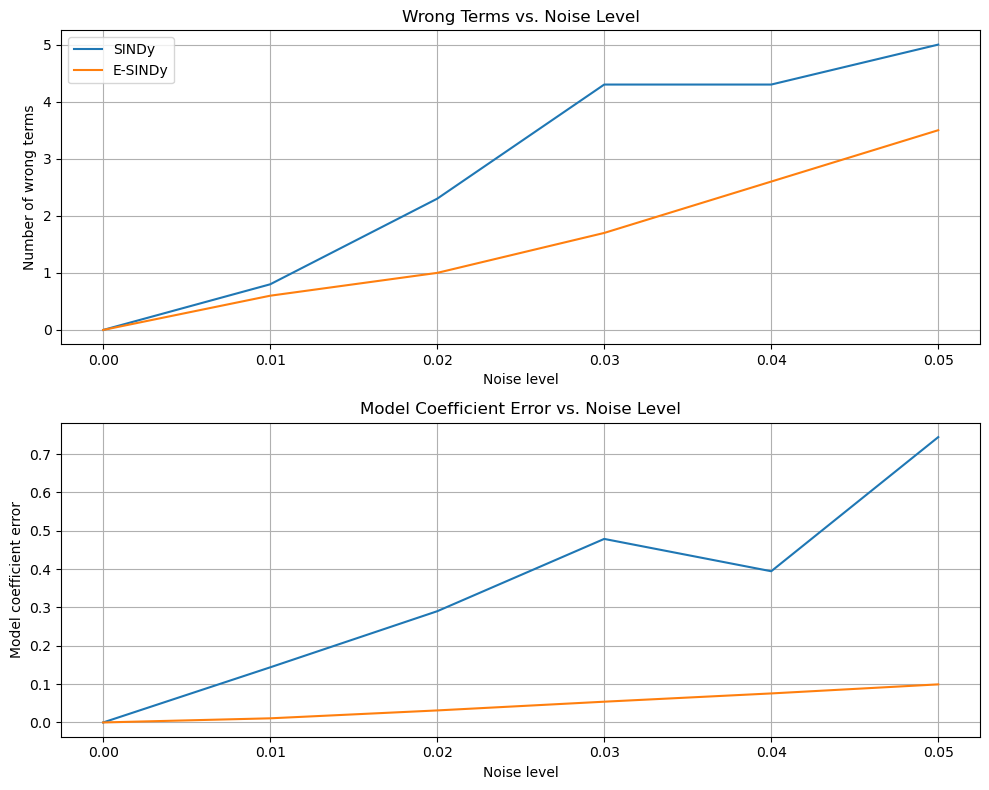

In [2]:
# Ensemble and SINDy hyperparameters
n_ensembles = 100
lambda_val = 0.2 # SINDy sparsification knob

# Noise level parameters
sig_nn = np.arange(0, 0.06, 0.01)
n_noise = len(sig_nn)
m_noise = 10 # Number of noise realizations

# Output arrays
nWrongTerms = np.zeros((n_noise, m_noise))
modelError = np.zeros((n_noise, m_noise))
nWrongTermsE = np.zeros((n_noise, m_noise))
modelErrorE = np.zeros((n_noise, m_noise))

poly_library = ps.PolynomialLibrary(degree=3, include_bias=True)
poly_library.fit(x_clean)
features = poly_library.get_feature_names()
n = 3 # number of states
m = len(features) # number of library features

feature_names = ['x', 'y', 'z']

# True coefficients matrix
true_coeffs = np.zeros((m, n))
# State 1 (x)
true_coeffs[1, 0] = -10
true_coeffs[2, 0] = 10
# State 2 (y)
true_coeffs[1, 1] = 28
true_coeffs[2, 1] = -1
true_coeffs[6, 1] = -1
# State 3 (z)
true_coeffs[3, 2] = -8/3
true_coeffs[5, 2] = 1


# Loop over noise realizations and levels
for mm in range(m_noise):
    for nn in range(n_noise):

        # Add noise
        np.random.seed(mm)
        x = x_clean + sig_nn[nn] * np.std(x_clean) * np.random.randn(*x_clean.shape)
    
        # Compute derivatives using a fourth-order finite difference
        differentiation_method = ps.FiniteDifference(order=4)
        
        # Build the library of terms
        poly_library = ps.PolynomialLibrary(degree=3, include_bias=True)
        
        # fit SINDy Model
        sindy_model = ps.SINDy(
            feature_library=poly_library,
            optimizer=ps.STLSQ(threshold=lambda_val),
            differentiation_method = differentiation_method
        )
        sindy_model.fit(x, t=dt) #, x_dot=dx)
        sindy_coeffs = sindy_model.coefficients()

        # fit E-SINDy Model: bragging
        ensemble_optimizer = ps.EnsembleOptimizer(ps.STLSQ(threshold=lambda_val), bagging=True, n_models=n_ensembles)
        esindy_model = ps.SINDy(
            feature_library=poly_library,
            optimizer=ensemble_optimizer,
            differentiation_method = differentiation_method
        )

        esindy_model.fit(x, t=dt, feature_names = feature_names) 
        
        # esindy_coeffs = esindy_model.coefficients() # coefficients of aggregated model (e.g. median model)
        ensemble_coefs = ensemble_optimizer.coef_list # all models
        median_ensemble = np.median(ensemble_coefs, axis=0)
        # std_ensemble = np.std(ensemble_coefs, axis=0)
        esindy_coeffs = median_ensemble
        
        # Compare SINDy vs. E-SINDy
        # SINDy metrics
        sindy_active = sindy_coeffs != 0
        true_active = true_coeffs != 0
        nWrongTerms[nn, mm] = np.sum(sindy_active != true_active.T)
        modelError[nn, mm] = np.linalg.norm(sindy_coeffs - true_coeffs.T) / np.linalg.norm(true_coeffs)

        # E-SINDy metrics
        esindy_active = esindy_coeffs != 0
        nWrongTermsE[nn, mm] = np.sum(esindy_active != true_active.T)
        modelErrorE[nn, mm] = np.linalg.norm(esindy_coeffs - true_coeffs.T) / np.linalg.norm(true_coeffs)

# Average over noise realizations
avg_nWrongTerms = np.mean(nWrongTerms, axis=1)
avg_modelError = np.mean(modelError, axis=1)
avg_nWrongTermsE = np.mean(nWrongTermsE, axis=1)
avg_modelErrorE = np.mean(modelErrorE, axis=1)

print("Comparison results:")
print("Noise Level | SINDy Wrong Terms | E-SINDy Wrong Terms | SINDy Error | E-SINDy Error")
print("-----------------------------------------------------------------------------------")
for i in range(n_noise):
    print(f"{sig_nn[i]:^11.2f} | {avg_nWrongTerms[i]:^17.2f} | {avg_nWrongTermsE[i]:^19.2f} | {avg_modelError[i]:^11.2f} | {avg_modelErrorE[i]:^13.2f}")


# plot results
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Number of Wrong Terms
axs[0].plot(sig_nn, avg_nWrongTerms, label='SINDy')
axs[0].plot(sig_nn, avg_nWrongTermsE, label='E-SINDy')
axs[0].set_xlabel('Noise level')
axs[0].set_ylabel('Number of wrong terms')
axs[0].legend(loc='upper left')  # Equivalent to MATLAB's 'northwest'
axs[0].set_title('Wrong Terms vs. Noise Level')
axs[0].grid(True)

# Model Coefficient Error
axs[1].plot(sig_nn, avg_modelError, label='SINDy')
axs[1].plot(sig_nn, avg_modelErrorE, label='E-SINDy')
axs[1].set_xlabel('Noise level')
axs[1].set_ylabel('Model coefficient error')
axs[1].set_title('Model Coefficient Error vs. Noise Level')
axs[1].grid(True)

plt.tight_layout()
plt.show()

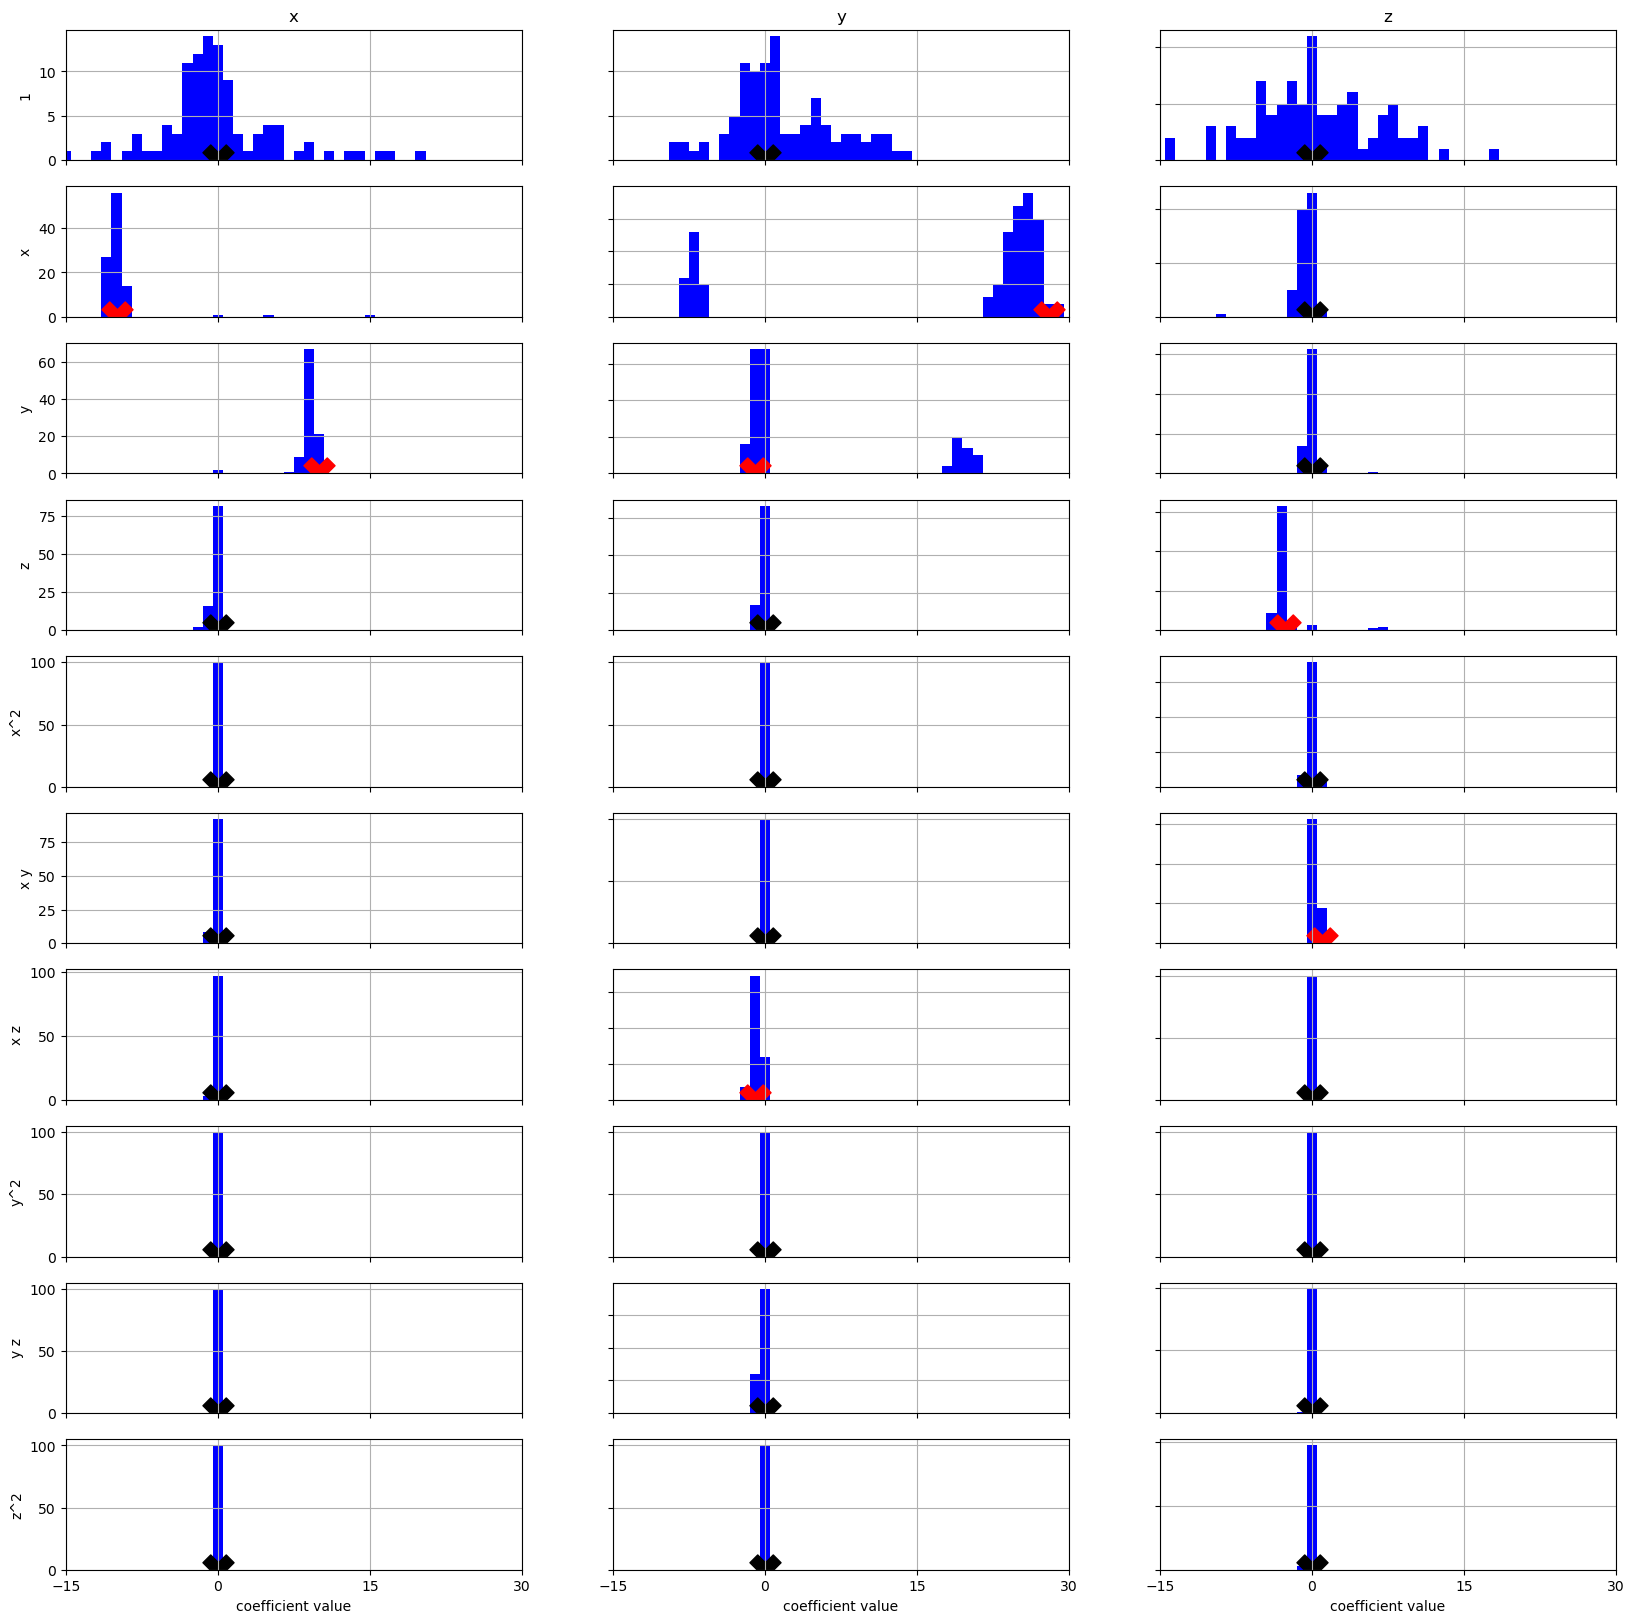

In [3]:
# Plot each coefficient distribution
plt.figure(figsize=(20, 20))
min_overall = -15
max_overall = 30

xticknames = esindy_model.get_feature_names()

ensemble_coefs = np.asarray(ensemble_optimizer.coef_list)

# Loop through each element in the coefficients
for j in range(10):
    for i in range(3):
        plt.subplot(10, 3, i + 1 + j * 3)
        if j == 0:
            plt.title(feature_names[i]) #, fontsize=30)
        bins = np.linspace(min_overall, max_overall, max_overall - min_overall + 1)
        plt.hist(ensemble_coefs[:, i, j], color='b', bins=bins, 
                 label='ensemble', align='left')
        if true_coeffs[j, i] != 0:
            plt.scatter(true_coeffs[j, i], 0.0, color='r', 
                        label='true value', s=500, marker='X')
        else:
            plt.scatter(true_coeffs[j, i], 0.0, color='k', 
                        label='true value', s=500, marker='X')
        plt.grid(True)
        ax = plt.gca()
        if i == 0:
            plt.ylabel(xticknames[j]) #, fontsize=30)
        else:
            ax.set_yticklabels([])
        if j != 9:
            ax.set_xticklabels([])
        else:
            plt.xlabel('coefficient value') #, fontsize=30)
        ax.set_xticks([min_overall, 0, max_overall // 2, max_overall])
        plt.xlim(min_overall, max_overall)
  